### Análise de Dados - Tecnologia Embarcada (.shp)

#### Análise de Operação de Colheita

Objetivo:

A análise tem como objetivo principal avaliar a produtividade do talhão, quantificada pela massa úmida por hectare 'Wet Mass'[kg/ha]. Como objetivos específicos destaco a identificação de possíveis outliers, que devem ser investigados para não afetarem a análise.

Dados:

Na análise abaixo foram utilizados dados disponibilizados no John Deere's Github, exemplificando dados obtidos com tecnologia embarcada, em uma colheita de soja. Os dados estão no formato Shapefile (.shp), saída padrão de arquivos da plataforma Operation Center - John Deere.

[1]. John Deere's Github: https://github.com/JohnDeere

#### Importando Bibliotecas e Pacotes .py

In [50]:
import pandas as pd
import shapefile
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

#Plot Matplotlib no Jupyter Notebook
%matplotlib inline

In [2]:
json_harv = pd.read_json("data\Export From MyJohnDeere - Harvest\doc\Merriweather Farms-JT-01-Soybeans-Deere-Metadata.json", orient = 'index')

json_harv

,0
Version,1.0
OrgId,223031
ClientId,46234f43-0000-1000-4014-e1e1e11124e0
ClientName,Merriweather Farms
FarmId,4641d448-0000-1000-4033-e1e1e11124e0
FarmName,JT
FieldId,e61b83f4-3a12-431e-8010-596f2466dc27
FieldName,01
Operation,Harvest
CropSeason,2016


#### Conhecendo os dados

##### Metadados

In [3]:
json_harv[0]['DataAttributes']

[{'Name': 'DISTANCE',
  'Unit': 'ft',
  'Description': 'Distance Travelled From Previous Point'},
 {'Name': 'SWATHWIDTH', 'Unit': 'ft', 'Description': 'Width Of Element'},
 {'Name': 'VRYIELDVOL', 'Unit': 'bu1ac-1', 'Description': 'Yield as Volume'},
 {'Name': 'SECTIONID', 'Description': 'Element Id'},
 {'Name': 'Crop', 'Description': 'CropId'},
 {'Name': 'Moisture', 'Unit': 'prcnt', 'Description': 'Moisture'},
 {'Name': 'WetMass', 'Unit': 'lb1ac-1', 'Description': 'Wet Mass'},
 {'Name': 'Time', 'Description': 'Timestamp'},
 {'Name': 'Heading', 'Description': 'Machine Heading'},
 {'Name': 'VARIETY', 'Description': 'Variety Name'},
 {'Name': 'Elevation', 'Unit': 'ft', 'Description': 'Elevation'},
 {'Name': 'IsoTime', 'Description': 'Precise Timestamp'}]

In [4]:
farm = json_harv[0]['FarmName']
field_name = str(json_harv[0]['FieldName'])
crop_season = str(json_harv[0]['CropSeason'])
crop_token = json_harv[0]['CropToken']

###### Lendo os dados

In [5]:
#Lendo arquivo .shp
sf = shapefile.Reader("data\Export From MyJohnDeere - Harvest\doc\Merriweather Farms-JT-01-Soybeans.shp")

shapes = sf.shapes()
head = [x[0] for x in sf.fields][1:]  #buscando cabeçalhos
records = [y[:] for y in sf.records()]  #buscando atributos
lat = [s.points[0][0] for s in sf.shapes()]  #buscando Latitude
long = [s.points[0][1] for s in sf.shapes()] #buscando Longtude

#Criando Dataframe para transformação dos dados
sf_df = pd.DataFrame(data = records, columns= head)

#Adicionando as informações Lat-Long ao Dataframe
sf_df['Lat'] = lat
sf_df['Long'] = long

#Convertendo o 'Time' de str para datetime
sf_df['Time'] = sf_df['IsoTime'].apply(lambda x: datetime.fromisoformat(x[:23]))

#Convertendo medidas do Sistema Americano para Sistema Internacional de Medidas
sf_df['DISTANCE'] = sf_df['DISTANCE']*0.3048 #m
sf_df['SWATHWIDTH'] = sf_df['SWATHWIDTH']*0.3048 #m
sf_df['Size'] = sf_df['DISTANCE']*sf_df['SWATHWIDTH']/10000 #ha
sf_df['VRYIELDVOL'] = sf_df['VRYIELDVOL']*(0.0352391)*(1/0.40469) #m³/ha
sf_df['WetMass'] = sf_df['WetMass']*(0.45359)*(1/0.40469) #kg/ha
sf_df['Elevation'] = sf_df['Elevation']*0.3048 #m

In [6]:
#Visão inicial dos dados
sf_df.head(3)

,DISTANCE,SWATHWIDTH,VRYIELDVOL,SECTIONID,Crop,WetMass,Moisture,Time,Heading,VARIETY,Elevation,IsoTime,Lat,Long,Size
0,0.010499,1.524,0.0,1260,174,0.0,4.56,2016-09-19 16:45:10,286.148407,23A42,239.709961,2016-09-19T16:45:10.000Z,-93.150270,41.666360,0.000002
1,0.010499,1.524,0.0,1261,174,0.0,4.56,2016-09-19 16:45:10,286.148407,23A42,239.709961,2016-09-19T16:45:10.000Z,-93.150265,41.666373,0.000002
2,0.010499,1.524,0.0,1262,174,0.0,4.56,2016-09-19 16:45:10,286.148407,23A42,239.709961,2016-09-19T16:45:10.000Z,-93.150260,41.666387,0.000002


In [7]:
#Estatísticas descritivas
sf_df.describe()

,DISTANCE,SWATHWIDTH,VRYIELDVOL,SECTIONID,Crop,WetMass,Moisture,Heading,Elevation,Lat,Long,Size
count,40960.000000,4.096000e+04,40960.000000,40960.000000,40960.0,40960.000000,40960.000000,40960.000000,40960.000000,40960.000000,40960.000000,40960.000000
mean,1.632539,1.524000e+00,6.796373,1262.496753,174.0,5266.777177,12.833751,187.950544,239.014467,-93.152299,41.667823,0.000249
std,0.278798,8.628759e-13,3.824762,1.703171,0.0,2967.944965,1.177402,100.498766,0.377862,0.001181,0.000872,0.000042
min,0.010499,1.524000e+00,0.000000,1260.000000,174.0,0.000000,0.000000,0.005000,237.630961,-93.154824,41.666154,0.000002
25%,1.531727,1.524000e+00,6.301931,1261.000000,174.0,4886.660298,12.240000,75.226874,238.822785,-93.153225,41.667102,0.000233
50%,1.690499,1.524000e+00,6.931147,1262.000000,174.0,5367.293726,12.870000,196.745282,239.075648,-93.152309,41.667876,0.000258
75%,1.805795,1.524000e+00,7.400767,1264.000000,174.0,5731.339346,13.610000,255.426532,239.255785,-93.151337,41.668556,0.000275
max,3.810499,1.524000e+00,145.104248,1265.000000,174.0,112083.323037,15.950000,359.945282,239.897277,-93.150244,41.669482,0.000581


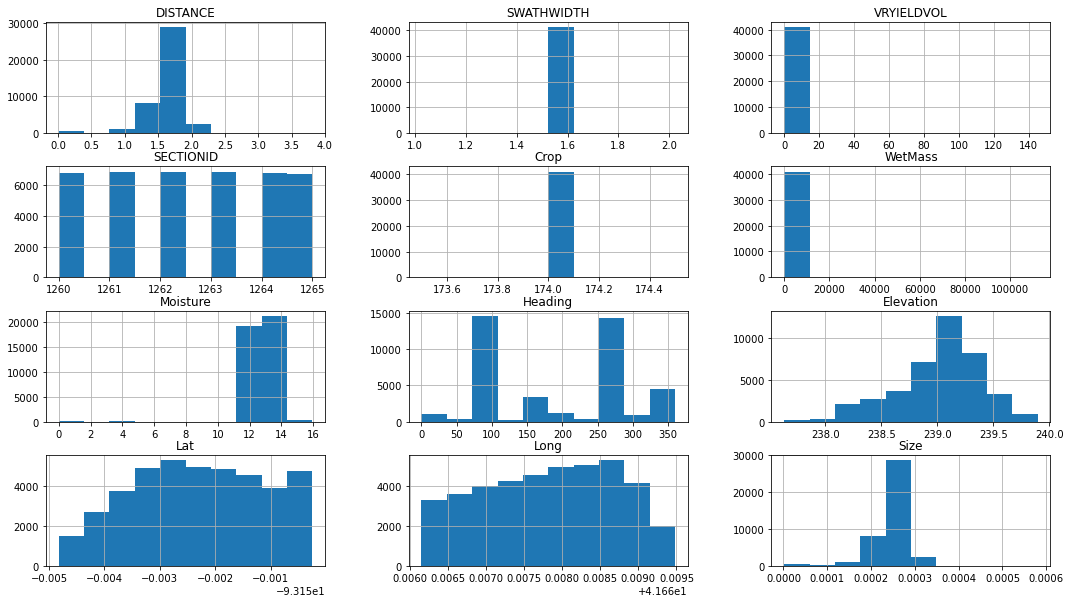

In [8]:
#Histograma - Overview
sf_df.hist(figsize=(18,10))
plt.show()

Obs.:

> Note não há variações variações de seção de trabalho ('SWATHWIDTH') ao longo da atividade .:. Médias não precisam ser ponderadas pela Área

> Houveram alguns pontos com altos valores de massa úmida por hectare ('WetMass'), estes devem ser investigados para não enviesarem a análise


##### Investigando Outliers

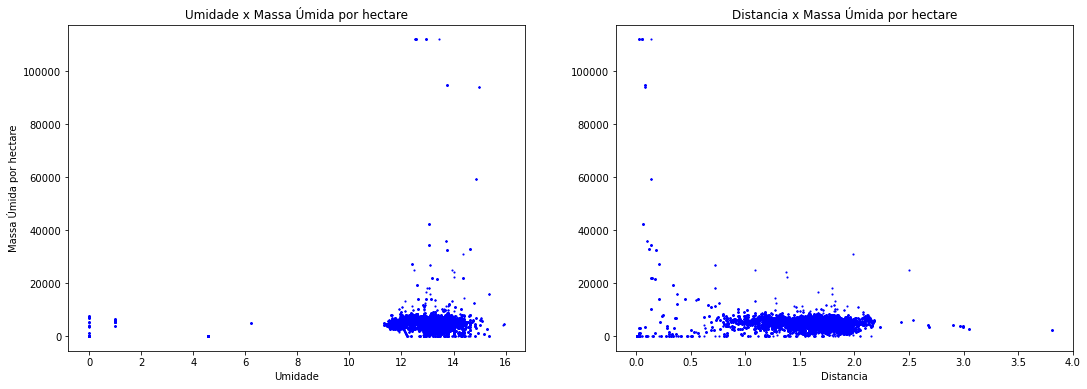

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axs[0].scatter(sf_df['Moisture'], sf_df['WetMass'], color = 'b', marker = '.', s = 5)
axs[0].set_title('Umidade x Massa Úmida por hectare')
axs[0].set_xlabel('Umidade')
axs[0].set_ylabel('Massa Úmida por hectare')

axs[1].scatter(sf_df['DISTANCE'], sf_df['WetMass'], color = 'b', marker = '.', s = 5)
axs[1].set_title('Distancia x Massa Úmida por hectare')
axs[1].set_xlabel('Distancia')

plt.show()

Obs.:

> Note os valores de WetMass elevados estão associados a umidades entre 12 e 16%

> Note ainda que este valores também estão associados a baixos deslocamentos 0-0.5m


.:. Possivelmente os valores elevados de WetMass estão relacionados a erros de leitura do sensor, em situações de embuxamento e/ou de baixas velocidades da colhedora, sendo assim desconsiderados na análise.


> Mas quais valores de WetMass serão considerados como outliers?

##### Analisando Percentis

In [47]:
sf_df['WetMass'].quantile([.1, .5, .75, .90, .95, .99])

0.10    3875.885390
0.50    5367.293726
0.75    5731.339346
0.90    6137.087999
0.95    6562.352024
0.99    7858.256234
Name: WetMass, dtype: float64

Note que 99% dos dados tem valor de WetMass inferior a 7859 kg/ha, optei por considerar outlier valores superiores a 2x média de WetMass (2x 5266.78), tendo assim baixo impacto nos dados e análises futuras.

In [68]:
#Retirando Outliers
sf_df_loc = sf_df[sf_df['WetMass']<2*sf_df['WetMass'].mean()]

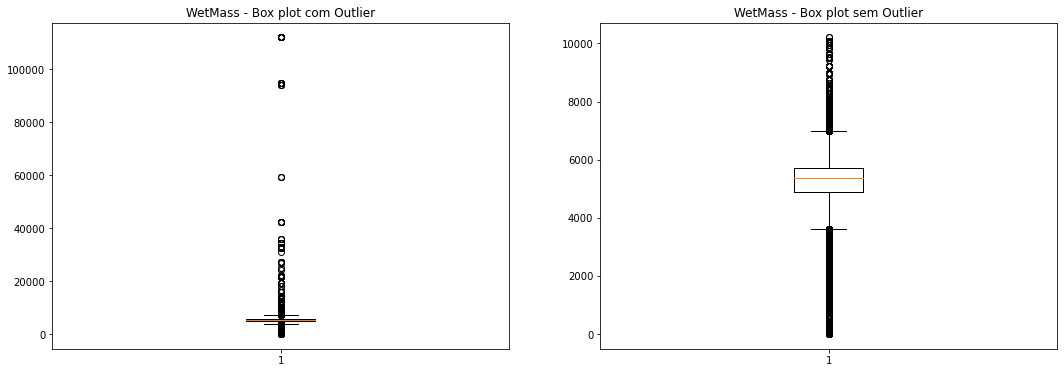

In [70]:
#Box plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axs[0].boxplot(sf_df['WetMass'])
axs[0].set_title('WetMass - Box plot com Outlier')

axs[1].boxplot(sf_df_loc['WetMass'])
axs[1].set_title('WetMass - Box plot sem Outlier')

plt.show()

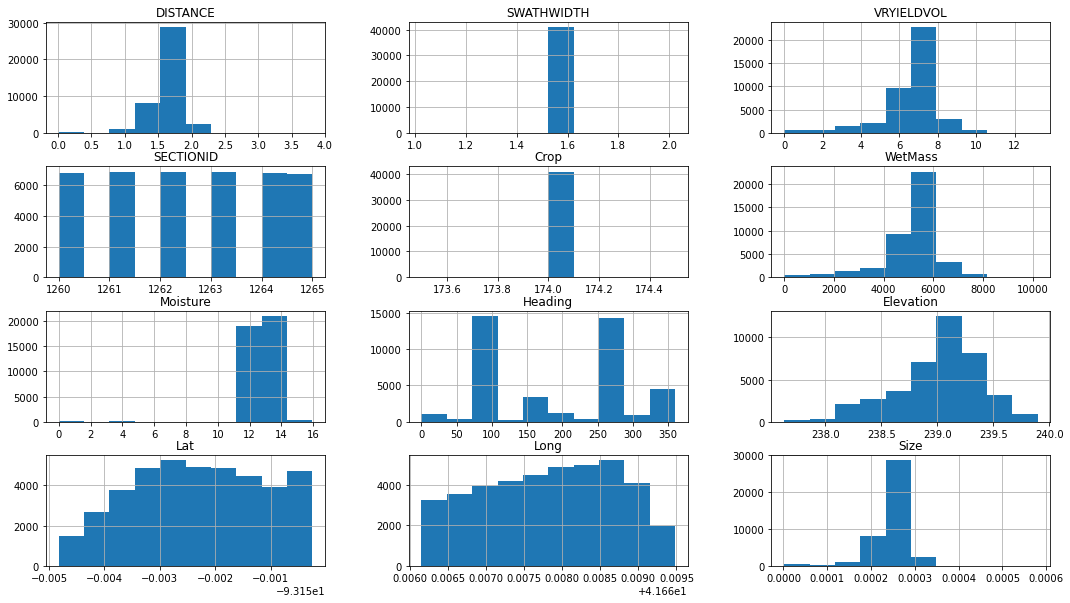

In [71]:
#Histograma - Overview - Sem Outlier
sf_df_loc.hist(figsize=(18,10))
plt.show()

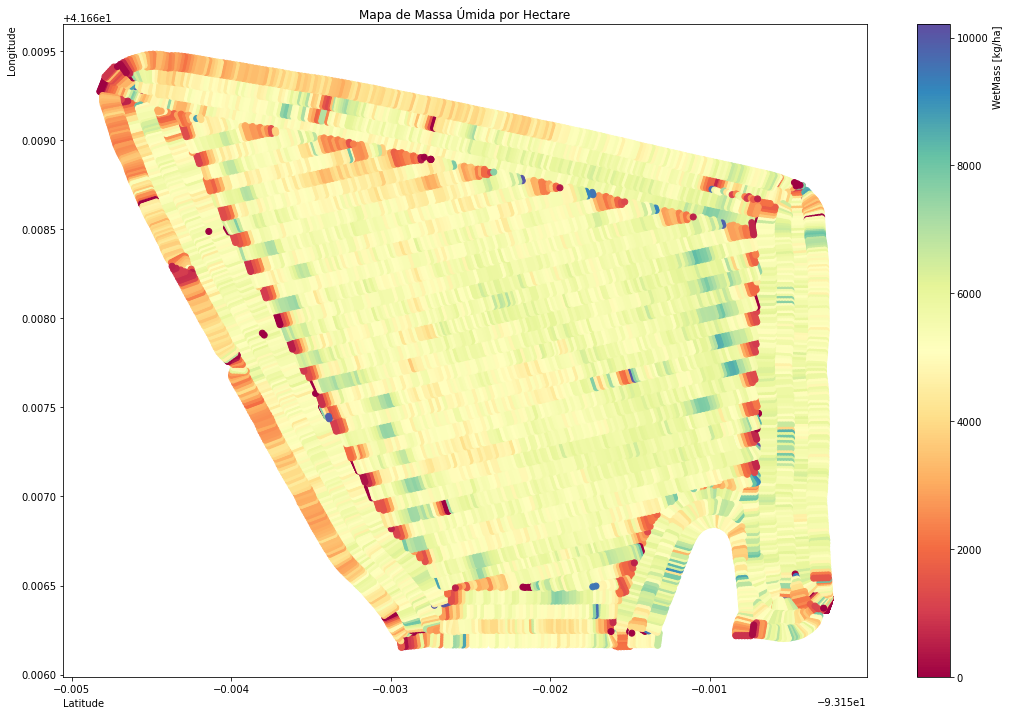

In [72]:
#Mapa de Massa Úmida por Hectare
fig, ax = plt.subplots(figsize = (18,12))

px = sf_df_loc['Lat']
py = sf_df_loc['Long']
pz = sf_df_loc['WetMass']

ax.set_title('Mapa de Massa Úmida por Hectare')
sc = ax.scatter(px, py, c=pz, cmap="Spectral")#"RdYlGn")
ax.set_ylabel('Longitude', loc='top')
ax.set_xlabel('Latitude', loc='left')
cbar = fig.colorbar(sc)
cbar.set_label("WetMass [kg/ha]", loc='top')

plt.show()

##### Próximos passos:

> Avaliar impacto de diferentes aplicações na produtividade do talhão

##### Veja também:

https://github.com/agomes94/tec_embarcada_application_shp